In [1]:
import os
import torch
#导入pytorch一个完整流程所需的可能全部的包
import torchvision
from torch import nn, optim
from torch.nn import functional as F
from torchvision import transforms as T
from torchvision import models as m
from torch.utils.data import DataLoader
torch.backends.cudnn.benchmark=True #用于加速GPU运算的代码
#导入作为辅助工具的各类包
import matplotlib.pyplot as plt #可视化
from time import time #计算时间、记录时间
import datetime
import random #控制随机性
import numpy as np
import pandas as pd
import gc #garbage collector 垃圾回收
# from plotpic import plotsample
from torchinfo import summary
# from EarlyStop import EarlyStopping
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
random.seed(1412) #random
np.random.seed(1412) #numpy.random
torch.cuda.manual_seed(1412)
torch.cuda.manual_seed_all(1412)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [21]:
#数据增强
# trainT = T.Compose([T.RandomResizedCrop(224)
#                    ,T.RandomRotation(degrees=[-5, 5])
#                    # ,T.RandomHorizontalFlip()
#                    ,T.ToTensor()
#                    ,T.Normalize(mean = [0.485, 0.456, 0.406]
#                                 ,std = [0.229, 0.224, 0.225])
#                      ])
# testT = T.Compose([
#                     T.CenterCrop(224)
#                       ,T.ToTensor()
#                       ,T.Normalize(mean = [0.485, 0.456, 0.406]
#                                    ,std = [0.229, 0.224, 0.225])
#                    ]
#                   )

trainT = T.Compose([T.RandomHorizontalFlip(), # 随机翻转图像
                    T.RandomCrop(32, padding=4), # 随机裁剪并在边缘填充
                    T.RandomRotation(15), # 随机旋转 +/- 15 度
                    T.Resize((64, 64)), # 修改图像大小
                    T.ToTensor()
                    ,T.Normalize(mean = [0.485, 0.456, 0.406]
                                    ,std = [0.229, 0.224, 0.225])
                    ])
testT = T.Compose([
    T.CenterCrop(224)
    ,T.ToTensor()
    ,T.Normalize(mean = [0.485, 0.456, 0.406]
                 ,std = [0.229, 0.224, 0.225])
]
)




In [22]:
train = torchvision.datasets.ImageFolder(root=r"F:\Data\New\train",
                                                 transform = trainT
                                                 )
test = torchvision.datasets.ImageFolder(root=r"F:\Data\New\test",
                                         transform = testT
                                         )

# num_samples = len(train)
# print(f"Number of samples in train dataset: {num_samples}")
# train = torchvision.datasets.SVHN(root = 'D://onedrive//OneDrive - yourdrive//Code//Notebook_workspace//SLPython//05Pytorch//Lesson 17//SVHN'
#                                   ,split = "train"
#                                   ,download = False
#                                   ,transform = trainT
#                                   )
# test = torchvision.datasets.SVHN(root = 'D://onedrive//OneDrive - yourdrive//Code//Notebook_workspace//SLPython//05Pytorch//Lesson 17//SVHN'
#                                  ,split = 'test'
#                                  ,download = False
#                                  ,transform = testT
#                                  )

In [6]:
import torchvision.transforms as T
from PIL import Image

# 获取一个样本（图像和标签）
sample_index = 500 # 可以选择任意索引
img, label = train[sample_index]

# 将张量图像转换回PIL图像
unnormalized_img = T.ToPILImage()(img)

# 显示图像和标签
print(f"Label: {label}")
unnormalized_img.show()


Label: 0


In [7]:
import torch
import torch.nn as nn
import torchvision.models as models

class MyResNet50(nn.Module):
    def __init__(self, num_classes=11):
        super(MyResNet50, self).__init__()
        resnet50 = models.resnet50(pretrained=True)

        # 保留resnet50的前几层
        self.conv1 = resnet50.conv1
        self.bn1 = resnet50.bn1
        self.relu = resnet50.relu
        self.maxpool = resnet50.maxpool
        self.layer1 = resnet50.layer1
        self.layer2 = resnet50.layer2
        self.layer3 = resnet50.layer3

        # 创建自定义的后3层
        self.layer4 = nn.Sequential(
            nn.Conv2d(1024, 2048, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(2048),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1))
        )

        self.fc = nn.Linear(2048, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
from torchinfo import summary
model = MyResNet50()
summary(model, (10,3, 22, 22), device=device)

C:\Users\admin\.conda\envs\python3.7\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
C:\Users\admin\.conda\envs\python3.7\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Layer (type:depth-idx)                   Output Shape              Param #
MyResNet50                               [10, 11]                  --
├─Conv2d: 1-1                            [10, 64, 11, 11]          9,408
├─BatchNorm2d: 1-2                       [10, 64, 11, 11]          128
├─ReLU: 1-3                              [10, 64, 11, 11]          --
├─MaxPool2d: 1-4                         [10, 64, 6, 6]            --
├─Sequential: 1-5                        [10, 256, 6, 6]           --
│    └─Bottleneck: 2-1                   [10, 256, 6, 6]           --
│    │    └─Conv2d: 3-1                  [10, 64, 6, 6]            4,096
│    │    └─BatchNorm2d: 3-2             [10, 64, 6, 6]            128
│    │    └─ReLU: 3-3                    [10, 64, 6, 6]            --
│    │    └─Conv2d: 3-4                  [10, 64, 6, 6]            36,864
│    │    └─BatchNorm2d: 3-5             [10, 64, 6, 6]            128
│    │    └─ReLU: 3-6                    [10, 64, 6, 6]            --
│ 

In [31]:
import torch
import torch.nn as nn
import torchvision.models as models

class MyResNet34(torch.nn.Module):
    def __init__(self, num_classes=11, pretrained=True, dropout_rate=0.5):
        super(MyResNet34, self).__init__()
        # 获取预训练的ResNet34模型并去除最后一层（全连接层）
        resnet34 = models.resnet34(pretrained=pretrained)
        resnet_without_fc = torch.nn.Sequential(*(list(resnet34.children())[:-1]))

        self.model = resnet_without_fc

        # 添加 Dropout 层
        self.dropout = torch.nn.Dropout(dropout_rate)

        # 添加自定义线性层以输出11个类
        self.fc = torch.nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.model(x)

        # 将输出展平以适用于全连接层
        x = x.view(x.size(0), -1)

        # 通过 Dropout 层
        x = self.dropout(x)

        # 添加最后的全连接层
        x = self.fc(x)

        return x

In [30]:
class MyResNet18(torch.nn.Module):
    def __init__(self, num_classes=11, dropout_rate=0.5):
        super(MyResNet18, self).__init__()

        resnet18 = models.resnet18(pretrained=False)
        original_layers = list(resnet18.children())

        # 我们只保留其中两个基本块，每个基本块包含两个残差块，因此我们删除了 2 * 2 = 4 个残差块
        reduced_resnet = nn.Sequential(
            *original_layers[:4],
            nn.Sequential(original_layers[4][0], original_layers[4][1]),
            nn.Sequential(original_layers[5][0], original_layers[5][1]),
            *original_layers[6:]
        )

        self.model = reduced_resnet[:-1]  # 除去原始 ResNet18 的全连接层

        # 添加 Dropout 层
        self.dropout = torch.nn.Dropout(dropout_rate)

        # 添加自定义线性层以输出11个类
        self.fc = torch.nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.model(x)

        # 将输出展平以适用于全连接层
        x = x.view(x.size(0), -1)

        # 通过 Dropout 层
        x = self.dropout(x)

        # 添加最后的全连接层
        x = self.fc(x)

        return x

In [34]:
import torch
import torchvision.models as models

class MyResNet101(torch.nn.Module):
    def __init__(self, num_classes=11, pretrained=True):
        super(MyResNet101, self).__init__()
        # 获取预训练的ResNet101模型并删除最后一层（全连接层）
        resnet101 = models.resnet101(pretrained=pretrained)
        resnet_without_fc = torch.nn.Sequential(*(list(resnet101.children())[:-1]))

        self.model = resnet_without_fc

        # 添加自定义层
        self.my_custom_layer1 = torch.nn.Linear(in_features=2048, out_features=1024)
        self.my_custom_layer2 = torch.nn.ReLU(inplace=True)
        self.my_custom_layer3 = torch.nn.Linear(in_features=1024, out_features=num_classes)

    def forward(self, inputs):
        x = self.model(inputs)

        # 将输出展平至适用于全连接层的维度
        x = x.view(x.size(0), -1)

        # 执行自定义层
        x = self.my_custom_layer1(x)
        x = self.my_custom_layer2(x)
        x = self.my_custom_layer3(x)

        return x
# model = MyResNet101()
# summary(model, (3, 20, 20), device=device)

In [24]:
class L1_Regularization:
    def __init__(self, lambda_l1):
        self.lambda_l1 = lambda_l1

    def __call__(self, model_parameters):
        l1_loss = 0
        for param in model_parameters:
            l1_loss += param.abs().sum()
        return self.lambda_l1 * l1_loss

In [9]:
class EarlyStopping():
    def __init__(self, patience = 20, tol = 0.005): #惯例地定义我们所需要的一切变量/属性\
        #当连续patience次迭代时，这一轮迭代的损失与历史最低损失之间的差值小于阈值时
        #就触发提前停止

        self.patience = patience
        self.tol = tol #tolerance，累积5次都低于tol才会触发停止
        self.counter = 0 #计数，计算现在已经累积了counter次
        self.lowest_loss = None
        self.early_stop = False #True - 提前停止，False - 不要提前停止

    def __call__(self,val_loss):
        if self.lowest_loss == None: #这是第一轮迭代
            self.lowest_loss = val_loss
        elif self.lowest_loss - val_loss > self.tol:
            self.lowest_loss = val_loss
            self.counter = 0
        elif self.lowest_loss - val_loss < self.tol:
            self.counter += 1
            print("\t NOTICE: Early stopping counter {} of {}".format(self.counter,self.patience))
            if self.counter >= self.patience:
                print('\t NOTICE: Early Stopping Actived')
                self.early_stop = True
        return self.early_stop
        #这一轮迭代的损失与历史最低损失之间的差 - 阈值

In [31]:
def IterOnce(net,criterion,opt,x,y):
    """
    对模型进行一次迭代的函数

    net: 实例化后的架构
    criterion: 损失函数
    opt: 优化算法
    x: 这一个batch中所有的样本
    y: 这一个batch中所有样本的真实标签
    """
    l1_regularization = L1_Regularization(lambda_l1=1e-3)
    sigma = net.forward(x)
    # loss = criterion(sigma,y)
    loss = criterion(sigma, y) + l1_regularization(net.parameters())
    loss.backward()
    opt.step()
    opt.zero_grad(set_to_none=True) #比起设置梯度为0，让梯度为None会更节约内存
    yhat = torch.max(sigma,1)[1]
    correct = torch.sum(yhat == y)
    return correct,loss

In [32]:
def TestOnce(net,criterion,x,y):
    """
    对一组数据进行测试并输出测试结果的函数

    net: 经过训练后的架构
    criterion：损失函数
    x：要测试的数据的所有样本
    y：要测试的数据的真实标签
    """
    #对测试，一定要阻止计算图追踪
    #这样可以节省很多内存，加速运算
    l1_regularization = L1_Regularization(lambda_l1=1e-3)
    with torch.no_grad():
        sigma = net.forward(x)
        # loss = criterion(sigma,y)
        loss = criterion(sigma, y) + l1_regularization(net.parameters())
        yhat = torch.max(sigma,1)[1]
        correct = torch.sum(yhat == y)
    return correct,loss

In [28]:
def fit_test(net, batchdata, testdata, criterion, opt, epochs, tol, modelname, PATH):

    SamplePerEpoch = batchdata.dataset.__len__()
    allsamples = SamplePerEpoch * epochs
    trainedsamples = 0
    trainlosslist = []
    testlosslist = []
    early_stopping = EarlyStopping(tol = tol)
    highestacc = None

    for epoch in range(1, epochs + 1):
        net.train()
        loss_train = 0
        correct_train = 0
        for batch_idx, (x, y) in enumerate(batchdata):
            x = x.to(device, non_blocking = True)
            y = y.to(device, non_blocking = True).view(x.shape[0])
            correct, loss = IterOnce(net, criterion, opt, x, y)
            trainedsamples += x.shape[0]
            loss_train += loss
            correct_train += correct

            if (batch_idx + 1) % 81 == 0:
                print('Epoch{}:[{}/{}({:.0f}%)]'.format( epoch
                                                         ,trainedsamples
                                                         ,allsamples
                                                         ,100*trainedsamples/allsamples))

        TrainAccThisEpoch = float(correct_train*100)/SamplePerEpoch
        TrainLossThisEpoch = float(loss_train*100)/SamplePerEpoch
        trainlosslist.append(TrainLossThisEpoch)

        del x, y, correct, loss, correct_train, loss_train
        gc.collect()
        torch.cuda.empty_cache()

        net.eval()
        loss_test = 0
        correct_test = 0
        TestSample = testdata.dataset.__len__()

        for x, y in testdata:
            with torch.no_grad():
                x = x.to(device, non_blocking = True)
                y = y.to(device, non_blocking = True).view(x.shape[0])
                correct, loss = TestOnce(net, criterion, x, y)
                loss_test += loss
                correct_test += correct

        TestAccThisEpoch = float(correct_test*100)/TestSample
        TestLossThisEpoch = float(loss_test*100)/TestSample
        testlosslist.append(TestLossThisEpoch)

        print("\t Train Loss:{:.6f}, Test Loss:{:.6f}, Train Acc:{:.3f}%, Test Acc:{:.3f}%".format(TrainLossThisEpoch ,TestLossThisEpoch, TrainAccThisEpoch, TestAccThisEpoch))

        if highestacc == None:
            highestacc = TestAccThisEpoch
        if highestacc < TestAccThisEpoch:
            highestacc = TestAccThisEpoch
            torch.save(net.state_dict(), os.path.join(PATH, modelname+".pt"))
            print("\t Weight Saved")


        #EarlyStopping
        early_stop = early_stopping(TestLossThisEpoch)
        if early_stop == True:
            break

    print("Mission Complete")
    return  trainlosslist,testlosslist


In [13]:
def full_procedure(net,epochs,bs,modelname, PATH, lr=0.001,alpha=0.99,gamma=0,wd=0,tol=10**(-5)):

    torch.manual_seed(1412)
    torch.cuda.manual_seed(1412)
    torch.cuda.manual_seed_all(1412)
    #分割数据
    batchdata = DataLoader(train,batch_size=bs,shuffle=True
                           ,drop_last=False, pin_memory=True) #线程 - 调度计算资源的最小单位
    testdata = DataLoader(test,batch_size=bs,shuffle=False
                          ,drop_last=False, pin_memory=True)

    #损失函数，优化算法
    criterion = nn.CrossEntropyLoss(reduction="sum") #进行损失函数计算时，最后输出结果的计算模式
    # opt = optim.RMSprop(net.parameters(),lr=lr
    #                     ,alpha=alpha,momentum=gamma,weight_decay=wd)
    opt = optim.SGD(net.parameters(),lr=lr
                        ,momentum=0.9,weight_decay=1e-2)
    #训练与测试
    trainloss, testloss = fit_test(net,batchdata,testdata,criterion,opt,epochs,tol,modelname,PATH)

    return trainloss, testloss

In [14]:
def plotloss(trainloss, testloss):
    plt.figure(figsize=(10, 7))
    plt.plot(trainloss, color="red", label="Trainloss")
    plt.plot(testloss, color="orange", label="Testloss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

Epoch1:[6480/4575000(0%)]
	 Train Loss:632.989727, Test Loss:930.049783, Train Acc:11.104%, Test Acc:6.452%
Epoch2:[15630/4575000(0%)]
	 Train Loss:510.828743, Test Loss:685.890741, Train Acc:12.044%, Test Acc:8.065%
	 Weight Saved
Epoch3:[24780/4575000(1%)]
	 Train Loss:484.241530, Test Loss:560.895316, Train Acc:13.563%, Test Acc:10.546%
	 Weight Saved
Epoch4:[33930/4575000(1%)]
	 Train Loss:465.466940, Test Loss:547.351815, Train Acc:13.508%, Test Acc:11.911%
	 Weight Saved
Epoch5:[43080/4575000(1%)]
	 Train Loss:448.377568, Test Loss:505.593595, Train Acc:14.317%, Test Acc:9.926%
Epoch6:[52230/4575000(1%)]
	 Train Loss:431.989699, Test Loss:644.762562, Train Acc:16.044%, Test Acc:11.414%
	 NOTICE: Early stopping counter 1 of 20
Epoch7:[61380/4575000(1%)]
	 Train Loss:415.569044, Test Loss:464.704831, Train Acc:16.852%, Test Acc:8.809%
Epoch8:[70530/4575000(2%)]
	 Train Loss:399.721257, Test Loss:460.629653, Train Acc:18.240%, Test Acc:11.166%
Epoch9:[79680/4575000(2%)]
	 Train Loss

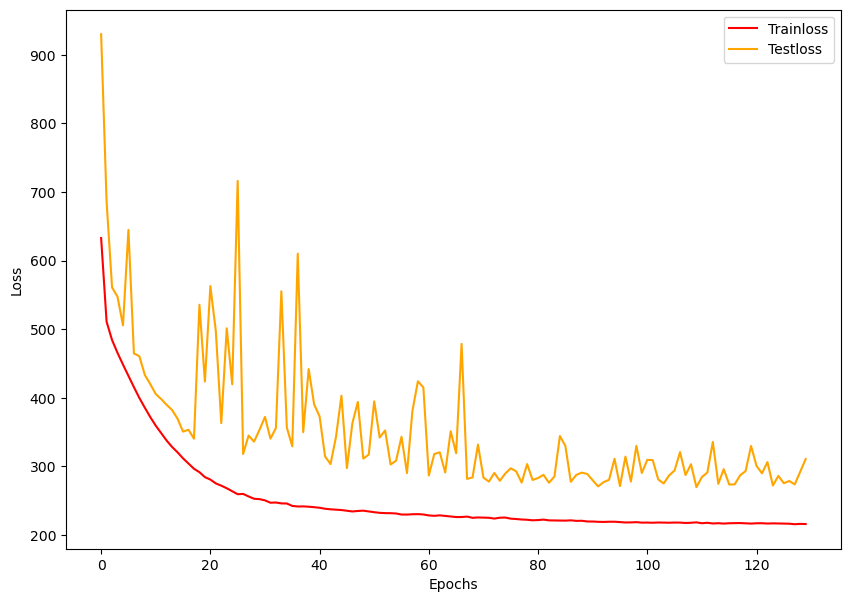

In [34]:
#建立目录用于存储模型选择结果
PATH = r"D:\Desktop"

#使用函数full_procedure中的默认参数，在模型选择时加入时间计算
#基于现有显存，batch_size被设置为256，对于CPU而言最好从64开始设置
#MyResNet
avgtime = [] #用来存放每次循环之后获得的训练时间
for i in range(1): #进行5次训练
    #设置随机数种子
    torch.manual_seed(42)
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
    #实例化
    # resnet18_ = m.resnet18()
    # resnet50_ = m.resnet50()
    # net = MyResNet50().to(device,non_blocking=True)

    # 实例化自定义模型
    net = MyResNet18(num_classes=11).to(device,non_blocking=True)
    # VGG_ = m.vgg16_bn()
    # net = MyVGG().to(device,non_blocking=True)
    #训练
    start = time() #计算训练时间
    trainloss, testloss = full_procedure(net,epochs=500, bs=80
                                         ,modelname="model_seletion_resnet50"
                                         ,PATH = PATH
                                         ,tol = 10**(-3))
    avgtime.append(time()-start)
    plotloss(trainloss,testloss)

In [33]:
# del net
gc.collect()
torch.cuda.empty_cache()
print(np.mean(avgtime))

nan


C:\Users\admin\.conda\envs\python3.7\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\admin\.conda\envs\python3.7\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
